# Aprendizado Supervisionado

Jaime Hikaru Mishima

## Small Business Administration (SBA) Historical Loans (7a and 504)
Over 1.6M loans guaranteed by the SBA to small businesses as part of their 7(a) and 504 Loan programs. Dataset includes including the name, address, and industry of the recipient as well as the loan amount, term current status and issuing bank details.

7(a) Loans: SBA 7(a) loans are for a maximum of 2 million dollars, with SBA loan guarantee of no more than 1.5 million dollars (75%).

504 Loans: The 504 Loan Program provides approved small businesses with long-term, fixed-rate financing used to acquire fixed assets for expansion or modernization. 504 loans are made available through Certified Development Companies (CDCs), SBA's community based partners for providing 504 Loans.

[Base Location](https://aws.amazon.com/marketplace/pp/prodview-27syih2hg4av2?qid=1587175655831&sr=0-25&ref_=srh_res_product_title#overview)
<br>
[Source](https://www.sba.gov/about-sba/open-government/foia#section-header-32)


## Previsão de Default em Empréstimos
**Contexto**: A Small Business Administration (SBA) é uma agência norte-americana que apoia as pequenas empresas. A SBA conecta empreendedores com credores e financiamento para ajudá-los a planejar, iniciar e expandir seus negócios. Com uma base histórica de empréstimos feitos desde 2009, a ideia é prever o não pagamento de acordo com variáveis de negócio.

## 0. Importar Bibliotecas

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
import fklearn, matplotlib
from tqdm import tqdm

# Variable selection based on Filter
from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.preprocessing import MinMaxScaler

# Variable selection base on Wrapper
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Variable selection based on Random Forest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from fklearn.preprocessing.splitting import time_split_dataset
from fklearn.preprocessing.splitting import space_time_split_dataset

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

In [57]:
pd.set_option('display.max_columns', None) # para mostrar todas as colunas

## 1. Tratamento da Base

In [7]:
# raw = pd.read_excel("FOIA - 7(a)(FY2010-Present).xlsx", sheet_name="7A_FY2010_Present")
# raw.to_csv("foia_7a.csv",index = False, header=True)

In [24]:
raw_base = pd.read_csv("foia_7a.csv")

In [25]:
df = raw_base.copy()
df.head()

,AsOfDate,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,BankName,BankStreet,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,PaidInFullDate,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported
0,20191231,7A,"CRESA PARTNERS - DENVER, INC.",7979 E TUFTS AVE PKWY STE 810,DENVER,CO,80237,"Zions Bank, A Division of",1 S Main St,SALT LAKE CITY,UT,84133,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.00,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.00,CORPORATION,PIF,2016-10-31,NaN,0,1,35
1,20191231,7A,The Hilltop Tavern,4757 Folsom Blvd,Sacramento,CA,95819,Plumas Bank,336 W Main St,QUINCY,CA,95971,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.00,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.00,CORPORATION,PIF,2019-03-31,NaN,0,0,6
2,20191231,7A,River City Car Wash LLC,649 Harbor Blvd,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",101 N Philips Ave,SIOUX FALLS,SD,57104,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.00,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.00,CORPORATION,CHGOFF,NaN,2015-08-24,320098,0,27
3,20191231,7A,Alphagraphics,71 Newtown Road.,Danbury,CT,6810,Union Savings Bank,226 Main St,DANBURY,CT,6810,100000,50000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.25,84,323110.00,Commercial Lithographic Printing,03512,"ALPHAGRAPHICS, PRINTSHOPS OF T",FAIRFIELD,CT,CONNECTICUT DISTRICT OFFICE,4.00,CORPORATION,EXEMPT,NaN,NaN,0,1,5
4,20191231,7A,ON SITE AUTOMOTIVE APPEARANCE,603 WOODBRIDGE COURT,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",9385 Haven Avenue,Rancho Cucamonga,CA,91730,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.00,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.00,INDIVIDUAL,PIF,2013-02-28,NaN,0,0,2


In [26]:
df['AsOfDate'] = df['AsOfDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['ApprovalDate'] = df['ApprovalDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['PaidInFullDate'] = df['PaidInFullDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['Target'] = np.where(df['PaidInFullDate'].isnull(), 1, 0)  

In [36]:
df['LoanStatus'].value_counts()

EXEMPT    262118
PIF       198609
CANCLD     62404
CHGOFF     18380
COMMIT     16031
Name: LoanStatus, dtype: int64

In [38]:
# vamos manter somente os emprestimos que foram totalmente pagos (PIF = Paid in Full) e cobrados (CHGOFF = Charged Off)
# COMMIT = não desembolsado, CANCLD = cancelado, EXEMPT = foram desembolsados mas não foram cancelados, cobrados ou pagos.
df = df[df['LoanStatus'].isin(['PIF', 'CHGOFF'])]

In [39]:
df.to_csv("foia_7a_tratado.csv",index = False, header=True)

In [192]:
df = pd.read_csv("foia_7a_tratado.csv")

In [193]:
#df['AsOfDate'] = df['AsOfDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['ApprovalDate'] = df['ApprovalDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df['FirstDisbursementDate'] = df['FirstDisbursementDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
#df['PaidInFullDate'] = df['PaidInFullDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [194]:
# removing unnused columns
df = df.drop(columns=['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BankStreet', 'LoanStatus'])

# removing variables related with target
df = df.drop(columns=['PaidInFullDate', 'ChargeOffDate', 'GrossChargeOffAmount'])

# converting categorical columns
df['NaicsCode'] = df['NaicsCode'].astype(str)
df['CongressionalDistrict'] = df['CongressionalDistrict'].astype(str)
df['BorrZip'] = df['BorrZip'].astype(str)
df['BankZip'] = df['BankZip'].astype(str)

df['Id'] = range(1, 1+len(df))
dados = df.copy()

In [195]:
dados.head()

,BorrCity,BorrState,BorrZip,BankName,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,RevolverStatus,JobsSupported,Target,Id
0,DENVER,CO,80237,"Zions Bank, A Division of",SALT LAKE CITY,UT,84133.0,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.0,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,1,35,0,1
1,Sacramento,CA,95819,Plumas Bank,QUINCY,CA,95971.0,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.0,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.0,CORPORATION,0,6,0,2
2,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",SIOUX FALLS,SD,57104.0,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.0,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.0,CORPORATION,0,27,1,3
3,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.0,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.0,INDIVIDUAL,0,2,0,4
4,CAMDEN,TN,38320,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,10000,9000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.24,120,453220.0,"Gift, Novelty, and Souvenir Stores",NaN,NaN,BENTON,TN,TENNESSEE DISTRICT OFFICE,7.0,INDIVIDUAL,0,3,0,5


## 2. Análise Exploratória

Análise exploratória serve para desvendar um pouco do processo gerador de dados. Quanto mais souber sobre como os dados são gerados, melhor será as chances de usar a técnica de modelagem mais adequada. Algumas análises são padrões em todos os processos de análise exploratória:

1. Análise de distribuição. Ex: qual a média, mínimo e máximo de cada variável
2. Análise de dados faltantes. Ex: Quais variáveis têm dados faltantes? Qual a proporção de dados faltantes por variável? Porque esses dados estão faltando? É um bug ou uma característica do processo gerador de dados?
3. Variáveis categóricas. Existem variáveis categóricas? Qual a cardinalidade das variáveis categóricas? As categorias são ordenadas ou sem ordem?
4. Correlação. Qual a correlação entre variáveis?
5. Censura: Quais as limitações do target? Há algum processo de espera temporal entre a observação das variáveis e a observação do target (em problemas de previsão, a resposta geralmente é sim!). Como é esse processo. Há alguma outra variável que limite o target?

In [140]:
dados.head(50)

,BorrCity,BorrState,BorrZip,BankName,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,RevolverStatus,JobsSupported,Target
0,DENVER,CO,80237,"Zions Bank, A Division of",SALT LAKE CITY,UT,84133.0,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.0,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,1,35,0
1,Sacramento,CA,95819,Plumas Bank,QUINCY,CA,95971.0,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.0,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.0,CORPORATION,0,6,0
2,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",SIOUX FALLS,SD,57104.0,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.0,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.0,CORPORATION,0,27,1
3,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.0,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.0,INDIVIDUAL,0,2,0
4,CAMDEN,TN,38320,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,10000,9000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.24,120,453220.0,"Gift, Novelty, and Souvenir Stores",NaN,NaN,BENTON,TN,TENNESSEE DISTRICT OFFICE,7.0,INDIVIDUAL,0,3,0
5,COLUMBIA,SC,29212,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,20000,18000,2009-10-01,2010,2009-10-01,PATRIOT EX,Patriot Express,7.75,120,541890.0,Other Services Related to Advertising,NaN,NaN,LEXINGTON,SC,SOUTH CAROLINA DISTRICT OFFICE,2.0,INDIVIDUAL,0,4,0
6,SPICER,MN,56288,Lake Region Bank,NEW LONDON,MN,56273.0,200000,100000,2009-10-01,2010,2009-12-01,SBA EXPRES,FA$TRK (Small Loan Express),7.50,60,236220.0,Commercial and Institutional Building Construc...,NaN,NaN,KANDIYOHI,MN,MINNESOTA DISTRICT OFFICE,7.0,CORPORATION,1,12,0
7,BOCA RATON,FL,33431,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,15000,13500,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,446199.0,All Other Health and Personal Care Stores,NaN,NaN,PALM BEACH,FL,SOUTH FLORIDA DISTRICT OFFICE,22.0,CORPORATION,0,1,0
8,SAN FRANCISCO,CA,94103,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,20000,18000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,722213.0,Snack and Nonalcoholic Beverage Bars,NaN,NaN,SAN FRANCISCO,CA,SAN FRANCISCO DISTRICT OFFICE,12.0,CORPORATION,0,4,0
9,Phoenix,IL,60426,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,44,441120.0,Used Car Dealers,NaN,NaN,COOK,IL,ILLINOIS DISTRICT OFFICE,1.0,CORPORATION,0,3,1


### 2.1 Análise de distribuição
Observamos alguns valores estranhos, por exemplo `TermInMonths` com máximo de `360`.

In [141]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GrossApproval,216989.00,313933.06,597664.30,1000.00,30000.00,100000.00,300000.00,5000000.00
SBAGuaranteedApproval,216989.00,233800.52,469588.56,500.00,17500.00,53000.00,204975.00,5250000.00
ApprovalFiscalYear,216989.00,2012.91,2.23,2010.00,2011.00,2013.00,2015.00,2019.00
InitialInterestRate,216989.00,6.32,1.43,0.00,5.50,6.00,7.05,12.50
TermInMonths,216989.00,104.08,73.26,0.00,60.00,84.00,120.00,360.00
RevolverStatus,216989.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
JobsSupported,216989.00,11.15,22.12,0.00,2.00,5.00,12.00,2150.00
Target,216989.00,0.08,0.28,0.00,0.00,0.00,0.00,1.00


### 2.2 Valores Nulos
Podemos ver que `FirstDisbursementDate`, `FranchiseCode`, `FranchiseName`,  tem valores nulos. Para a franquia, somente 7% da base tem o campo preenchido.

Podemos ver que ~8% da base não pagou o empréstimo (`PaidInFullDate` está nulo ou `ChargeOffDate` está preenchido).

In [142]:
dados.isna().mean()

BorrCity                0.00
BorrState               0.00
BorrZip                 0.00
BankName                0.00
BankCity                0.00
BankState               0.00
BankZip                 0.00
GrossApproval           0.00
SBAGuaranteedApproval   0.00
ApprovalDate            0.00
ApprovalFiscalYear      0.00
FirstDisbursementDate   0.00
DeliveryMethod          0.00
subpgmdesc              0.00
InitialInterestRate     0.00
TermInMonths            0.00
NaicsCode               0.00
NaicsDescription        0.00
FranchiseCode           0.93
FranchiseName           0.93
ProjectCounty           0.00
ProjectState            0.00
SBADistrictOffice       0.00
CongressionalDistrict   0.00
BusinessType            0.00
RevolverStatus          0.00
JobsSupported           0.00
Target                  0.00
dtype: float64

### 2.3 Cardinalidade
Sexo, PerfilEconomico, RegiaodoPais, PerfilCompra tem baixa cardinalidade

In [143]:
dados.apply(pd.Series.nunique).sort_values()

Target                       2
RevolverStatus               2
BusinessType                 3
ApprovalFiscalYear          10
DeliveryMethod              15
subpgmdesc                  17
BankState                   54
CongressionalDistrict       55
BorrState                   57
ProjectState                57
SBADistrictOffice           74
JobsSupported              284
TermInMonths               325
NaicsDescription          1175
NaicsCode                 1202
InitialInterestRate       1321
ProjectCounty             1789
BankCity                  1889
FranchiseName             2183
BankZip                   2504
FirstDisbursementDate     2696
BankName                  2751
FranchiseCode             2785
ApprovalDate              3051
GrossApproval            12192
SBAGuaranteedApproval    16879
BorrCity                 19226
BorrZip                  19571
dtype: int64

### 2.5 Correlação
Queremos ver quais as variáveis que estão mais relacionadas com o target de alguma forma.

*TermsInMonths* parece ser uma variável bem forte, seguido de *InitialInterestRate*.

In [144]:
target = 'Target'
dados.corr(method='pearson')[target].sort_values()

TermInMonths            -0.17
GrossApproval           -0.06
SBAGuaranteedApproval   -0.06
JobsSupported           -0.03
ApprovalFiscalYear       0.00
RevolverStatus           0.00
InitialInterestRate      0.13
Target                   1.00
Name: Target, dtype: float64

É importante olhar como as features estão relacionadas entre si. 

Por exemplo, não queremos usar duas features muito correlacionadas no modelo ao mesmo tempo.

(8.0, 0.0)

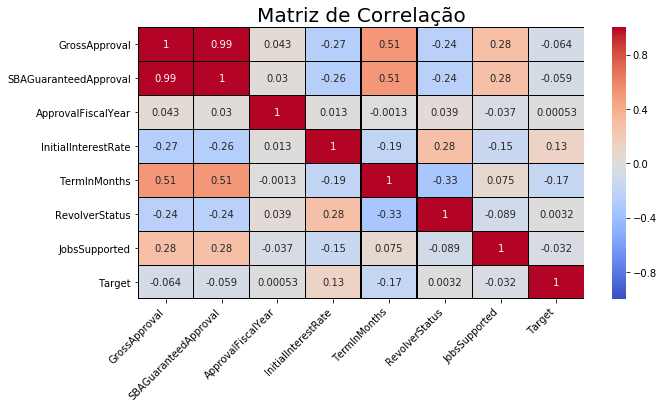

In [145]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(dados.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=0.5, linecolor='black')

# rotate xlabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax.axes.set_title("Matriz de Correlação",fontsize=20)
#ax.set_xlabel("X Label",fontsize=30)
#ax.set_ylabel("Y Label",fontsize=20)
ax.tick_params(labelsize=10)

# adjust plot
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## 3. Tratamento dos Dados
Imputação, dummies. Geracao da ABT de modelagem

In [146]:
dados.head()

,BorrCity,BorrState,BorrZip,BankName,BankCity,BankState,BankZip,GrossApproval,SBAGuaranteedApproval,ApprovalDate,ApprovalFiscalYear,FirstDisbursementDate,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,FranchiseCode,FranchiseName,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,RevolverStatus,JobsSupported,Target
0,DENVER,CO,80237,"Zions Bank, A Division of",SALT LAKE CITY,UT,84133.0,250000,125000,2009-10-01,2010,2009-10-01,SBA EXPRES,FA$TRK (Small Loan Express),5.26,84,531210.0,Offices of Real Estate Agents and Brokers,NaN,NaN,DENVER,CO,COLORADO DISTRICT OFFICE,1.0,CORPORATION,1,35,0
1,Sacramento,CA,95819,Plumas Bank,QUINCY,CA,95971.0,233500,210150,2009-10-01,2010,2009-10-01,PLP,Guaranty,6.00,120,722410.0,Drinking Places (Alcoholic Beverages),NaN,NaN,SACRAMENTO,CA,SACRAMENTO DISTRICT OFFICE,6.0,CORPORATION,0,6,0
2,West Sacramento,CA,95691,"Wells Fargo Bank, National Association",SIOUX FALLS,SD,57104.0,683900,615510,2009-10-01,2010,2009-11-01,PLP,Guaranty,5.25,210,811192.0,Car Washes,NaN,NaN,YOLO,CA,SACRAMENTO DISTRICT OFFICE,3.0,CORPORATION,0,27,1
3,MIDDLEBURY,IN,46540,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,12500,11250,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.75,120,811121.0,"Automotive Body, Paint, and Interior Repair an...",NaN,NaN,ELKHART,IN,INDIANA DISTRICT OFFICE,2.0,INDIVIDUAL,0,2,0
4,CAMDEN,TN,38320,"VelocitySBA, LLC",Rancho Cucamonga,CA,91730.0,10000,9000,2009-10-01,2010,2009-10-01,COMM EXPRS,Community Express,7.24,120,453220.0,"Gift, Novelty, and Souvenir Stores",NaN,NaN,BENTON,TN,TENNESSEE DISTRICT OFFICE,7.0,INDIVIDUAL,0,3,0


In [183]:
year_volume = dados['ApprovalDate'].groupby(dados["ApprovalDate"].dt.year).count().to_frame()#.plot(kind="bar")
year_volume = year_volume.rename(columns={"ApprovalDate": "Count Loans"})
year_volume['Share Loans'] = year_volume['Count Loans'].div(year_volume['Count Loans'].sum(), axis=0).multiply(100)
year_volume

,Count Loans,Share Loans
ApprovalDate,,
2009,9412,4.34
2010,39286,18.11
2011,32848,15.14
2012,30604,14.10
2013,26304,12.12
2014,28031,12.92
2015,22700,10.46
2016,15669,7.22
2017,8717,4.02


Text(0.5, 1.0, 'Volume de Loans anual')

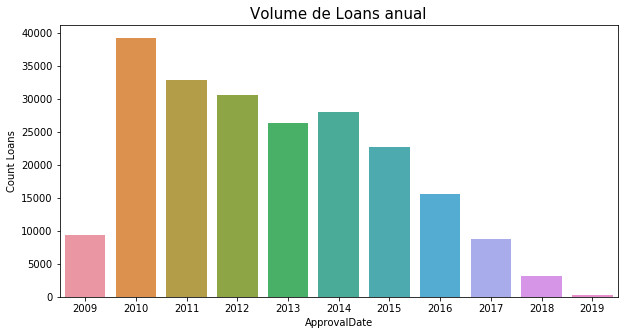

In [177]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=year_volume.index, y='Count Loans',data=year_volume, dodge=False)
ax.axes.set_title("Volume de Loans anual",fontsize=15)

In [179]:
dados['ApprovalDate'].min()

Timestamp('2009-10-01 00:00:00')

In [180]:
dados['ApprovalDate'].max()

Timestamp('2019-09-30 00:00:00')

In [520]:
split_fn = space_time_split_dataset(train_start_date="2009-10-01",
                                    train_end_date="2014-12-31",
                                    holdout_end_date="2019-09-30",
                                    split_seed=42,
                                    space_holdout_percentage=0.2,
                                    space_column="Id",
                                    time_column="ApprovalDate")

dados_amostral = dados.sample(n = 10000)
train_set, out_of_space_ho, out_of_time_ho, out_of_space_time_ho =  split_fn(dados_amostral)

In [521]:
print(train_set.shape)
print(out_of_space_ho.shape)
print(out_of_time_ho.shape)
print(out_of_space_time_ho.shape)

(6179, 29)
(1544, 29)
(2277, 29)
(0, 29)


### 3.1 Imputação

Imputação de mediana nas variáveis numéricas (no caso serve apenas para ValorCompraAnual).

Imputação de `unk` (para unknown) para as variáveis categóricas (não se aplica para essa base).

In [522]:
numerical_variables = dados.describe().transpose().index.tolist()
categorical_variables = list(set(dados.columns.tolist()) - set(numerical_variables))
numerical_variables.remove('Target')
numerical_variables.remove('Id')
print('Variveis numericas: ',numerical_variables)
print('Variveis categoricas: ',categorical_variables)

Variveis numericas:  ['GrossApproval', 'SBAGuaranteedApproval', 'ApprovalFiscalYear', 'InitialInterestRate', 'TermInMonths', 'RevolverStatus', 'JobsSupported']
Variveis categoricas:  ['BorrCity', 'NaicsDescription', 'BorrZip', 'NaicsCode', 'SBADistrictOffice', 'DeliveryMethod', 'ApprovalDate', 'ProjectState', 'BankCity', 'FirstDisbursementDate', 'FranchiseCode', 'subpgmdesc', 'BusinessType', 'BankState', 'BankZip', 'BorrState', 'BankName', 'CongressionalDistrict', 'ProjectCounty', 'FranchiseName']


In [523]:
from fklearn.training.imputation import imputer, placeholder_imputer
from toolz import compose

num_impute_learner = imputer(columns_to_impute=numerical_variables,
                             impute_strategy="median")

cat_impute_learner = placeholder_imputer(columns_to_impute=categorical_variables,
                                          placeholder_value="unk")

#tupla que retorna: [0] a funcao, [1] dataset e [2] log
num_impute_fn, _, num_impute_log = num_impute_learner(train_set)
cat_impute_fn, _, cat_impute_log = cat_impute_learner(train_set)

compose(num_impute_fn, cat_impute_fn)(train_set).isnull().mean()

BorrCity                0.00
BorrState               0.00
BorrZip                 0.00
BankName                0.00
BankCity                0.00
BankState               0.00
BankZip                 0.00
GrossApproval           0.00
SBAGuaranteedApproval   0.00
ApprovalDate            0.00
ApprovalFiscalYear      0.00
FirstDisbursementDate   0.00
DeliveryMethod          0.00
subpgmdesc              0.00
InitialInterestRate     0.00
TermInMonths            0.00
NaicsCode               0.00
NaicsDescription        0.00
FranchiseCode           0.00
FranchiseName           0.00
ProjectCounty           0.00
ProjectState            0.00
SBADistrictOffice       0.00
CongressionalDistrict   0.00
BusinessType            0.00
RevolverStatus          0.00
JobsSupported           0.00
Target                  0.00
Id                      0.00
dtype: float64

### 3.2 Tratamento Outliers, Dummies e Label encoder
Aplica-se um **capper** para valores acima de um certo valor e o **foorer** para aplicar um threshold inferior. Não se aplica na base.

**One hot encoder** para variáveis categóricas com baixa cardinalidade.

**Label encoder** para variáveis categóricas com alta cardinalidade.

In [524]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
GrossApproval,216989.00,313933.06,597664.30,1000.00,30000.00,100000.00,300000.00,5000000.00
SBAGuaranteedApproval,216989.00,233800.52,469588.56,500.00,17500.00,53000.00,204975.00,5250000.00
ApprovalFiscalYear,216989.00,2012.91,2.23,2010.00,2011.00,2013.00,2015.00,2019.00
InitialInterestRate,216989.00,6.32,1.43,0.00,5.50,6.00,7.05,12.50
TermInMonths,216989.00,104.08,73.26,0.00,60.00,84.00,120.00,360.00
RevolverStatus,216989.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
JobsSupported,216989.00,11.15,22.12,0.00,2.00,5.00,12.00,2150.00
Target,216989.00,0.08,0.28,0.00,0.00,0.00,0.00,1.00
Id,216989.00,108495.00,62639.47,1.00,54248.00,108495.00,162742.00,216989.00


In [525]:
from fklearn.training.transformation import capper, floorer
from fklearn.training.transformation import label_categorizer
from fklearn.training.transformation import onehot_categorizer

# Capping altos
capper_fn = capper(columns_to_cap=['GrossApproval', 'SBAGuaranteedApproval'], 
                   precomputed_caps={'GrossApproval': 5000000,
                                     'SBAGuaranteedApproval': 5250000
                                    })

# One hot encoding (cria dummies)
categorical_features_onehot = ['BusinessType', 'DeliveryMethod', 'subpgmdesc']
oh_encode_learner = onehot_categorizer(columns_to_categorize=categorical_features_onehot,
                                       hardcode_nans=False, # hardcodes an extra column with 1 if nan or unseen else 0
                                       drop_first_column=True)

# Label encoding
categorical_features_label_encoding = list(set(categorical_variables) - set(categorical_features_onehot) 
                                           - set(['ApprovalDate']))
le_encode_learner = label_categorizer(
                                columns_to_categorize=categorical_features_label_encoding,
                                store_mapping=True,
)

## 4. Pipeline

In [526]:
from fklearn.training.pipeline import build_pipeline

pipeline_learner = build_pipeline(
    capper_fn,
    num_impute_learner,
    cat_impute_learner,
    oh_encode_learner,
    le_encode_learner
)

In [527]:
## Using the created pipeline I transform my data
_, pre_processed_data, _ = pipeline_learner(dados)
#_, pre_processed_data, _ = pipeline_learner(dados_amostral)

In [528]:
train_set, out_of_space_ho, out_of_time_ho, out_of_space_time_ho =  split_fn(pre_processed_data)

In [477]:
train_set.columns.tolist()

['BorrCity',
 'BorrState',
 'BorrZip',
 'BankName',
 'BankCity',
 'BankState',
 'BankZip',
 'GrossApproval',
 'SBAGuaranteedApproval',
 'ApprovalDate',
 'ApprovalFiscalYear',
 'FirstDisbursementDate',
 'InitialInterestRate',
 'TermInMonths',
 'NaicsCode',
 'NaicsDescription',
 'FranchiseCode',
 'FranchiseName',
 'ProjectCounty',
 'ProjectState',
 'SBADistrictOffice',
 'CongressionalDistrict',
 'RevolverStatus',
 'JobsSupported',
 'Target',
 'Id',
 'fklearn_feat__BusinessType==CORPORATION',
 'fklearn_feat__BusinessType==INDIVIDUAL',
 'fklearn_feat__BusinessType==PARTNERSHIP',
 'fklearn_feat__BusinessType==unk',
 'fklearn_feat__DeliveryMethod==CA',
 'fklearn_feat__DeliveryMethod==CLP',
 'fklearn_feat__DeliveryMethod==COMM EXPRS',
 'fklearn_feat__DeliveryMethod==DFP',
 'fklearn_feat__DeliveryMethod==EWCP',
 'fklearn_feat__DeliveryMethod==EXIM',
 'fklearn_feat__DeliveryMethod==EXPRES EXP',
 'fklearn_feat__DeliveryMethod==GO LOANS',
 'fklearn_feat__DeliveryMethod==INTER TRDE',
 'fklearn_fea

## 5. Métodos de Seleção
Filtro, wrapper, embedded

In [529]:
# cols = ['Target', 'fklearn_feat__PerfilEconomico==3', 'fklearn_feat__Sexo==mulher', 'fklearn_feat__PerfilCompra==8','fklearn_feat__RegiaodoPais==Região Sul']
# train_df_copy = train_df
# test_df_copy = test_df
# for col in cols:
#     if col in train_df_copy.columns:
#         train_df_copy = train_df_copy.drop(columns=col, axis=1)
#     if col in test_df_copy.columns:
#         test_df_copy = test_df_copy.drop(columns=col, axis=1)

explicativas_train = train_set[list(set(train_set) - set(['ApprovalFiscalYear', 'ApprovalFiscalYear', 'ApprovalDate', 'FirstDisbursementDate', 'Target']))]
target_train = train_set['Target']

explicativas_test = out_of_time_ho[list(set(out_of_time_ho) - set(['ApprovalFiscalYear', 'ApprovalFiscalYear', 'ApprovalDate', 'FirstDisbursementDate', 'Target']))]
target_test = out_of_time_ho['Target']

### 5.1 Baseado em Filtro

In [530]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

x_norm = MinMaxScaler().fit_transform(explicativas_train)

# chamada do objeto
chi2_selector = SelectKBest(chi2)

chi2_selector.fit(x_norm, target_train)

chi_s = chi2_selector.get_support()

chi_feature = explicativas_train.loc[:,chi_s].columns.tolist()
print(str(len(chi_feature)), 'variaveis selecionadas')
print(chi_feature)

10 variaveis selecionadas
['TermInMonths', 'fklearn_feat__DeliveryMethod==PATRIOT EX', 'fklearn_feat__subpgmdesc==Lender Advantage Initiative', 'fklearn_feat__subpgmdesc==Patriot Express', 'fklearn_feat__subpgmdesc==FA$TRK (Small Loan Express)', 'fklearn_feat__DeliveryMethod==PLP', 'fklearn_feat__DeliveryMethod==SBA EXPRES', 'fklearn_feat__subpgmdesc==Community Express', 'fklearn_feat__DeliveryMethod==COMM EXPRS', 'fklearn_feat__DeliveryMethod==SLA']


### 5.2 Wrapper

In [531]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# chamada do objeto
rfe_selector = RFE(estimator=LogisticRegression(), step=10) #default is half, n_features_to_select=10)

rfe_selector.fit(explicativas_train, target_train)
rfe_support = rfe_selector.get_support()
rfe_feature = explicativas_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'variaveis selecionadas:')
print(rfe_feature)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


29 variaveis selecionadas:
['TermInMonths', 'NaicsDescription', 'InitialInterestRate', 'fklearn_feat__BusinessType==CORPORATION', 'NaicsCode', 'fklearn_feat__DeliveryMethod==PATRIOT EX', 'RevolverStatus', 'SBADistrictOffice', 'fklearn_feat__subpgmdesc==Guaranty', 'fklearn_feat__subpgmdesc==Lender Advantage Initiative', 'fklearn_feat__subpgmdesc==Patriot Express', 'ProjectState', 'fklearn_feat__subpgmdesc==Revolving Line of Credit Exports - Sec. 7(a) (14)', 'BankCity', 'FranchiseCode', 'fklearn_feat__DeliveryMethod==OTH 7A', 'BankState', 'fklearn_feat__subpgmdesc==FA$TRK (Small Loan Express)', 'BankZip', 'BorrState', 'BankName', 'fklearn_feat__DeliveryMethod==PLP', 'CongressionalDistrict', 'fklearn_feat__DeliveryMethod==SBA EXPRES', 'fklearn_feat__subpgmdesc==Community Express', 'fklearn_feat__DeliveryMethod==COMM EXPRS', 'fklearn_feat__DeliveryMethod==SLA', 'JobsSupported', 'FranchiseName']


### 5.3 Random Forest

In [532]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

em_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
em_selector.fit(explicativas_train, target_train)

em_sup = em_selector.get_support()
em_feature = explicativas_train.loc[:,em_sup].columns.tolist()
print(str(len(em_feature)), 'variaveis selecionadas:')
print(em_feature)

19 variaveis selecionadas:
['BorrCity', 'TermInMonths', 'Id', 'NaicsDescription', 'BorrZip', 'InitialInterestRate', 'NaicsCode', 'SBAGuaranteedApproval', 'SBADistrictOffice', 'ProjectState', 'BankCity', 'GrossApproval', 'BankState', 'BankZip', 'BorrState', 'BankName', 'CongressionalDistrict', 'ProjectCounty', 'JobsSupported']


### 5.4 Comparando Filtro, Wrapper e Random Forest

In [533]:
feature_selection_df = pd.DataFrame({'Variaveis':explicativas_train.columns,
                                     'chi2':chi_s,
                                     'RFE': rfe_support,
                                     'Random forest': em_sup})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total', 'Variaveis'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [534]:
feature_selection_df

,Variaveis,chi2,RFE,Random forest,Total
1,TermInMonths,True,True,True,3
2,fklearn_feat__subpgmdesc==Patriot Express,True,True,False,2
3,fklearn_feat__subpgmdesc==Lender Advantage Ini...,True,True,False,2
4,fklearn_feat__subpgmdesc==FA$TRK (Small Loan E...,True,True,False,2
5,fklearn_feat__subpgmdesc==Community Express,True,True,False,2
6,fklearn_feat__DeliveryMethod==SLA,True,True,False,2
7,fklearn_feat__DeliveryMethod==SBA EXPRES,True,True,False,2
8,fklearn_feat__DeliveryMethod==PLP,True,True,False,2
9,fklearn_feat__DeliveryMethod==PATRIOT EX,True,True,False,2
10,fklearn_feat__DeliveryMethod==COMM EXPRS,True,True,False,2


Selecionando features que apareceram em pelo menos dois métodos de seleção de variáveis:

In [535]:
var_select = feature_selection_df[feature_selection_df['Total'] > 1]['Variaveis'].tolist()

In [536]:
x_treino = explicativas_train[var_select]
y_treino = target_train

x_teste = explicativas_test[var_select]
y_teste = target_test

## 6. Modelagem usando Gridsearch e Cross Validation Kfold: Regressao Logística, Random Forest e Gradient Boosting)

### 6.1.1 Regressão Logística

In [537]:
from sklearn.linear_model import LogisticRegression
RL = LogisticRegression(random_state=42)

Dicionário de hyperparâmetros para o **GridSearch** da Regressão Logística

In [538]:
hyperparameters = {"C":np.logspace(-3,3,7), 
                   "penalty":["l1","l2"]} # l1 lasso l2 ridge

In [539]:
%%time
grid_RL = GridSearchCV(RL, 
                  hyperparameters, 
                  cv=10,
                  verbose=0)
grid_RL.fit(x_treino, y_treino)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

CPU times: user 6min 1s, sys: 9.08 s, total: 6min 10s
Wall time: 7min 3s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [489]:
grid_RL.best_params_

{'C': 1.0, 'penalty': 'l1'}

Passo os melhores parametros do Gridsearch como argumentos na LogisticRegression():

In [490]:
RL = LogisticRegression(**grid_RL.best_params_, random_state=42)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [491]:
%%time
acuracias_RL_treino = cross_val_score(estimator=RL,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_RL_teste = cross_val_score(estimator=RL,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

CPU times: user 19.4 s, sys: 940 ms, total: 20.3 s
Wall time: 18.9 s


/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [492]:
print('REGRESSAO LOGISTICA - Acuracia de Treino:',round(acuracias_RL_treino.mean()*100,2))
print('REGRESSAO LOGISTICA - Acuracia de Teste:',round(acuracias_RL_teste.mean()*100,2))

REGRESSAO LOGISTICA - Acuracia de Treino: 91.94
REGRESSAO LOGISTICA - Acuracia de Teste: 89.95


### 6.1.2 Random Forest

Dicionário de hyperparâmetros para o **GridSearch** da Random Forest

In [545]:
%%time
from sklearn.ensemble import RandomForestClassifier

parametros_grid = {
    'n_estimators':[5,10],
    'criterion':['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap':[True, False],
    'min_samples_leaf': [3],
    'max_depth':[5]
}

RF = RandomForestClassifier(random_state=123)

CPU times: user 83 µs, sys: 1.41 ms, total: 1.5 ms
Wall time: 5.89 ms


In [546]:
%%time
from sklearn.model_selection import GridSearchCV

grid_RF = GridSearchCV(estimator=RF,
                    param_grid=parametros_grid,
                    scoring='accuracy',
                    cv=5)
grid_RF.fit(x_treino, y_treino)

CPU times: user 48.8 s, sys: 2.49 s, total: 51.3 s
Wall time: 54 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [547]:
grid_RF.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 5}

In [548]:
grid_RF.best_score_

0.9268136952961855

Passo os melhores parâmetros do Gridsearch como argumentos na RandomForestClassifier():

In [549]:
%%time
RF = RandomForestClassifier(**grid_RF.best_params_, random_state=42)
RF.fit(x_treino, y_treino)

CPU times: user 354 ms, sys: 5.6 ms, total: 359 ms
Wall time: 361 ms


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [550]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_RF_treino = cross_val_score(estimator=RF,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_RF_teste = cross_val_score(estimator=RF,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

CPU times: user 4.53 s, sys: 249 ms, total: 4.78 s
Wall time: 4.82 s


In [551]:
print('RANDOM FOREST - Acuracia de Treino:',round(acuracias_RF_treino.mean()*100,2))
print('RANDOM FOREST - Acuracia de Teste:',round(acuracias_RF_teste.mean()*100,2))

RANDOM FOREST - Acuracia de Treino: 92.14
RANDOM FOREST - Acuracia de Teste: 91.68


### 6.1.3 Gradient Boosting

In [554]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=42)

Dicionário de hyperparâmetros para o **GridSearch** do Gradient Boosting

In [555]:
parametros_gb = {'min_samples_split': [3, 5],
                 'min_samples_leaf': [3, 5],
                 'max_depth': [3,5],
                 'n_estimators':[2,5],
                 'loss':['deviance'],
                 'learning_rate': [0.05, 0.2],
                 'max_features':["log2","sqrt"],
                 #'criterion': ["friedman_mse",  "mae"],
                 #'subsample':[0.5,0.8, 1.0]
                }

In [556]:
%%time
from sklearn.model_selection import GridSearchCV

# assinatura do objeto
grid_GB = GridSearchCV(estimator=GB,
                       param_grid=parametros_gb,
                       cv=5,
                       n_jobs=-1) # tenta rodar em paralelo, se possível
grid_GB.fit(x_treino, y_treino)

CPU times: user 2.38 s, sys: 1.02 s, total: 3.4 s
Wall time: 1min 9s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  subsample=1.0, tol

In [557]:
grid_GB.best_score_

0.9243573757192434

In [558]:
grid_GB.best_params_

{'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 5}

Passo os melhores parâmetros do Gridsearch como argumentos na GradientBoostingClassifier():

In [559]:
%%time
GB = GradientBoostingClassifier(**grid_GB.best_params_, random_state=42)
GB.fit(x_treino, y_treino)

CPU times: user 564 ms, sys: 31.4 ms, total: 595 ms
Wall time: 631 ms


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=5,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [560]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_GB_treino = cross_val_score(estimator=GB,
                            X = x_treino,
                            y = y_treino,
                            cv=5)

acuracias_GB_teste = cross_val_score(estimator=GB,
                            X = x_teste,
                            y = y_teste,
                            cv=5)

CPU times: user 3.08 s, sys: 280 ms, total: 3.36 s
Wall time: 3.5 s


In [561]:
print('GRADIENT BOOSTING - Acuracia de Treino:',round(acuracias_GB_treino.mean()*100,2))
print('GRADIENT BOOSTING - Acuracia de Teste:',round(acuracias_GB_teste.mean()*100,2))

GRADIENT BOOSTING - Acuracia de Treino: 92.44
GRADIENT BOOSTING - Acuracia de Teste: 92.41


### 6.1.4 XGBoosting

In [592]:
%%time
from sklearn.metrics import roc_auc_score, log_loss
# An experiment to understand why weak learners work better:
max_depth = np.unique(np.random.randint(3, 15, size=7))
num_estimators = np.unique(np.concatenate((np.random.randint(3, 15, size=7), np.random.randint(15, 100, size=5)),axis=0))

auc = pd.DataFrame()

for depth in max_depth:
    for tot_trees in num_estimators:
        
        xgb_ = XGBClassifier(max_depth=depth, num_estimators=tot_trees)
        xgb_.fit(x_treino, y_treino)
        
        test_xgb  = xgb_.predict_proba(x_teste)[:,1]
        auc_test  = roc_auc_score(y_teste.values, test_xgb)
        

        auc = pd.concat([auc, pd.DataFrame(data={'AUC': [auc_test], 'max_depth':[depth] , 'num_estimators':[tot_trees]})], axis=0)
        print(auc)

   AUC  max_depth  num_estimators
0 0.97          4               4
   AUC  max_depth  num_estimators
0 0.97          4               4
0 0.97          4               5
   AUC  max_depth  num_estimators
0 0.97          4               4
0 0.97          4               5
0 0.97          4               7
   AUC  max_depth  num_estimators
0 0.97          4               4
0 0.97          4               5
0 0.97          4               7
0 0.97          4               9
   AUC  max_depth  num_estimators
0 0.97          4               4
0 0.97          4               5
0 0.97          4               7
0 0.97          4               9
0 0.97          4              11


KeyboardInterrupt: 

In [613]:
from xgboost import XGBClassifier

XGB = XGBClassifier(random_state=42)

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters_xgb = {#'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['binary:logistic'],
                  'learning_rate': [0.05,0.1], #so called `eta` value
                  'max_depth': [2],
                  'min_child_weight': [11],
                  #'silent': [1],
                  #'subsample': [0.8],
                  #'colsample_bytree': [0.7],
                  'n_estimators': [8], #number of trees, change it to 1000 for better results
                  #'missing':[-999],
                  #'seed': [1337],
                  'lambda':[1.2, 1.3],
                  'alpha':[1.2, 1.3],

                 }

In [614]:
%%time
from sklearn.model_selection import GridSearchCV

# assinatura do objeto
grid_XGB = GridSearchCV(estimator=XGB,
                       param_grid=parameters_xgb,
                       cv=5,
                       n_jobs=-1) # tenta rodar em paralelo, se possível
grid_XGB.fit(x_treino, y_treino)

CPU times: user 1.46 s, sys: 214 ms, total: 1.68 s
Wall time: 23.9 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1.2, 1.3], 'lambda': [1.2, 1.3],
                         'learning_rate': [0.05, 0.1], 'max_depth': [2],
                         'm

In [615]:
grid_XGB.best_params_

{'alpha': 1.2,
 'lambda': 1.2,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 11,
 'n_estimators': 8,
 'objective': 'binary:logistic'}

Passo os melhores parâmetros do Gridsearch como argumentos na XGBClassifier():

In [616]:
%%time
XGB = XGBClassifier(**grid_XGB.best_params_, random_state=42)
XGB.fit(x_treino, y_treino)

CPU times: user 1.17 s, sys: 23.1 ms, total: 1.2 s
Wall time: 1.23 s


XGBClassifier(alpha=1.2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, lambda=1.2,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=11, missing=None, n_estimators=8, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [617]:
%%time
from sklearn.model_selection import cross_val_score
acuracias_XGB_treino = cross_val_score(estimator=XGB,
                            X = x_treino,
                            y = y_treino,
                            cv=5)

acuracias_XGB_teste = cross_val_score(estimator=XGB,
                            X = x_teste,
                            y = y_teste,
                            cv=5)

CPU times: user 7.34 s, sys: 344 ms, total: 7.69 s
Wall time: 9.37 s


In [618]:
print('GRADIENT BOOSTING - Acuracia de Treino:',round(acuracias_XGB_treino.mean()*100,2))
print('GRADIENT BOOSTING - Acuracia de Teste:',round(acuracias_XGB_teste.mean()*100,2))

GRADIENT BOOSTING - Acuracia de Treino: 92.08
GRADIENT BOOSTING - Acuracia de Teste: 90.83


### 6.1.4 Comparando Modelos

In [619]:
modelos = pd.DataFrame({'Modelo': ['Regressao Logistica',
                                   'Random Forest',
                                   'Gradient Boosting',
                                   'XGboosting'
                                  ],
                        'Acuracia_treino':[round(acuracias_RL_treino.mean()*100,2), 
                                           round(acuracias_RF_treino.mean()*100,2),
                                           round(acuracias_GB_treino.mean()*100,2),
                                           round(acuracias_XGB_treino.mean()*100,2)],
                        'Acuracia_teste':[round(acuracias_RL_teste.mean()*100,2), 
                                          round(acuracias_RF_teste.mean()*100,2),
                                          round(acuracias_GB_teste.mean()*100,2),
                                          round(acuracias_XGB_teste.mean()*100,2)]
                       })

comparacao = modelos.sort_values(by='Acuracia_teste', ascending=False)
comparacao = comparacao[['Modelo', 'Acuracia_treino', 'Acuracia_teste']]

In [620]:
comparacao

,Modelo,Acuracia_treino,Acuracia_teste
2,Gradient Boosting,92.44,92.41
1,Random Forest,92.14,91.68
3,XGboosting,92.08,90.83
0,Regressao Logistica,91.94,89.95


## 7. Salvando Modelo

Melhores estimadores do melhor modelo (com maior acurácia foi o Gradient Boosting):

In [516]:
grid_GB.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=8,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [517]:
from sklearn.externals import joblib

# salva modelo Gradient Boosting
joblib.dump(grid_GB.best_estimator_, 'modelo_loan_gb_total.pkl', compress = 1)

['modelo_loan_gb_total.pkl']

In [518]:
# salva modelo Random Forest
joblib.dump(grid_RF.best_estimator_, 'modelo_loan_rf_total.pkl', compress = 1)

['modelo_loan_rf_total.pkl']

In [519]:
# salva modelo Regressao Logistica
joblib.dump(grid_RL.best_estimator_, 'modelo_loan_rl_total.pkl', compress = 1)

['modelo_loan_rl_total.pkl']

## 8. Recuperando Modelo Salvo

In [329]:
modelo_treinado = open('modelo_loan_gb.pkl', 'rb')
model = joblib.load(modelo_treinado)

In [330]:
model.predict(x_teste)

array([0, 0, 0, ..., 0, 0, 0])

In [331]:
model.predict_proba(x_teste)[:,1]

array([0.01869136, 0.01975793, 0.01962957, ..., 0.08265626, 0.01965564,
       0.02335925])